# Load Libraries & Data

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

In [3]:
import os
import sys

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np

from SepMe.graph import *

SepMe - INFO - MLFLOW_TRACKING_URI - http://localhost:5000


In [4]:
data_path = '/Users/morarica/Developer/SepMe/data/binary_data/RESULTS_EUROVIS2015.csv'
folder_path = "/Users/morarica/Developer/SepMe/data/binary_data/EUROVIS_new/"
os.getcwd()

'/Users/morarica/Developer/SepMe/Jupyters/scripts_sanitychecks'

In [5]:
df = pd.read_csv(data_path)
#print(df.head())

for i, file in enumerate(df.fileName):
    file_name = folder_path + file.split('.csv')[0] + '_cls' + str(df.classNum[i]) + '.csv'
    try:
        sample_df = pd.read_csv(file_name, names=['x','y','class'])
        break
        #print(sample_df.head(1))
    except FileNotFoundError:
        print('File \'' + file +'\' does not exist.')

sample_df.head()
df = sample_df
df = df.astype({'x': 'float64', 'y':'float64'})

folder = '../../data/orig_data/input_data/enhanced_dim_data/'
df = pd.read_csv(folder + 'tse300_d6-d12.csv')

193
{0, 1, 2, 3, 4, 5, 6, 7}


,x,y,class,orig_class
0,0.000000,0.069444,4,4
1,0.019231,0.250000,4,4
2,0.038462,0.194444,4,4
3,0.038462,0.263889,0,0
4,0.057692,0.013889,4,4
5,0.057692,0.138889,4,4
6,0.057692,0.152778,4,4
7,0.057692,0.277778,4,4
8,0.076923,0.041667,4,4
9,0.096154,0.000000,4,4


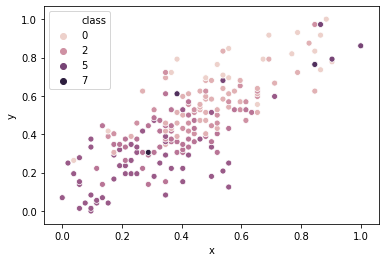

In [6]:
#df = sample_df
#df = pd.read_csv('/Users/morarica/Developer/SepMe/data/orig_data/input_data/enhanced_dim_data/cars03Cropped_d1_iso2-tsn1.csv')
sns.scatterplot(df.x,df.y, hue = df['class'])

print(len(df))
print(set(df['class']))
df.head(10)



# Construct Neighbourhood Graphs

SepMe - INFO - Metric logged: get_knntree_time=0.00415
SepMe - INFO - Metric logged: get_knntree_time=0.00477
SepMe - INFO - Metric logged: get_rng_time=1.74396
SepMe - INFO - Metric logged: get_cbsg_time=0.44112


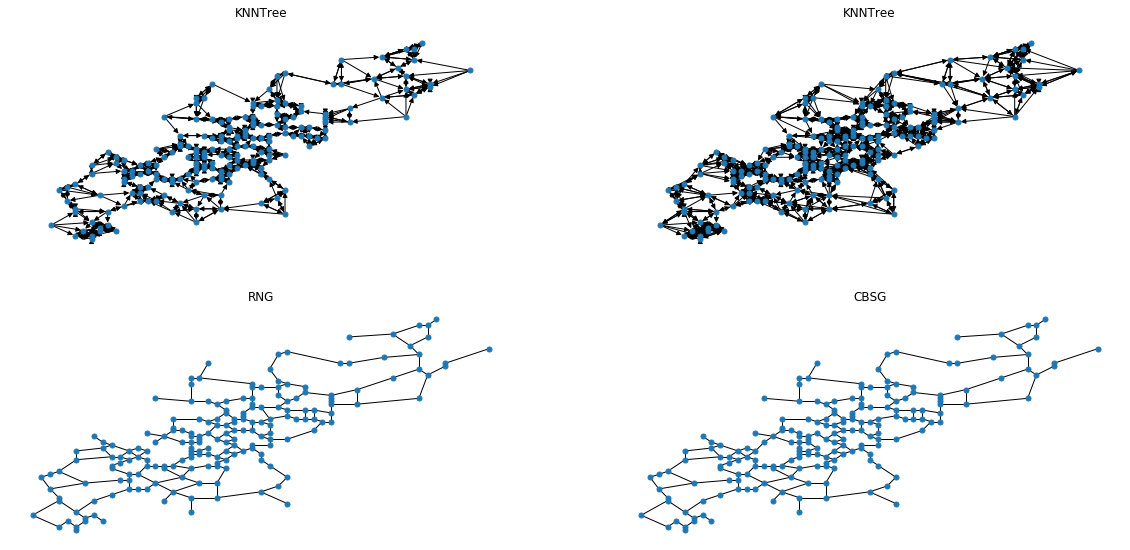

In [8]:
pointIDXY = dict(zip(range(len(df[['x','y']])), np.array(df[['x','y']])))

f = plt.figure(figsize=(20,20))

# test Delauney
graph_del = get_delaunay(df)
plt.subplot(421, figure = f, title = 'Deulaunay')
nx.draw(graph_del, pointIDXY, node_size=25)



# test EMST
graph_mst = get_mst(graph_del)
plt.subplot(422, figure = f, title = 'EMST')
nx.draw(graph_mst, pointIDXY, node_size=25)


# test KNNtree
graph = get_knntree(df,4)
plt.subplot(421, figure = f, title = 'KNNTree')
nx.draw(graph, pointIDXY, node_size=25)

# test KNNtree
graph = get_knntree(df,6)
plt.subplot(422, figure = f, title = 'KNNTree')
nx.draw(graph, pointIDXY, node_size=25)

# # test KNCG
# graph_kncg = get_kncg(df, 2)
# plt.subplot(424, figure = f, title = 'KNCG')
# nx.draw(graph_kncg, pointIDXY, node_size=25)


# # test BallTree
# graph = get_balltree(df, 50)
# plt.subplot(425, figure = f, title = 'BallTree')
# nx.draw(graph, pointIDXY, node_size=25)


# # test Convex Hull (CH)
# graph_ch = get_convex_hull(df)
# plt.subplot(426, figure = f, title = 'CH')
# nx.draw(graph_ch, pointIDXY, node_size=25)


# # test GONG
# gong = get_gong(df, 0.3)
# plt.subplot(426, figure = f, title = 'GONG')
# nx.draw(gong, pointIDXY, node_size=25) 


graph_rng = get_rng(df, graph_del, graph_mst)
plt.subplot(423, figure = f, title = 'RNG')
nx.draw(graph_rng, pointIDXY, node_size=25)


# test CBSG
graph_cbsg = get_cbsg(df, 2)
plt.subplot(424, figure = f, title = 'CBSG')
nx.draw(graph_cbsg, pointIDXY, node_size=25) 

plt.show()

In [29]:
all_mcec(graph_cbsg, df, 100)

Index(['x', 'y', 'class', 'orig_class', 'pos', 'class_0', 'class_1', 'class_2',
       'class_3', 'class_4', 'class_5', 'class_6', 'class_7'],
      dtype='object')
[147  38  40  39  48  46  47  34  47  40  40  43  42  45  41  43  44  45
  43  44  39  40  37  45  36  43  40  41  43  39  43  41  36  42  36  44
  40  37  47  43  45  41  44  42  46  45  41  41  37  42  45  38  43  39
  45  43  38  44  44  46  45  42  46  40  37  43  44  41  36  50  43  40
  40  41  47  39  47  44  41  38  50  42  46  44  42  44  44  35  43  42
  37  40  44  37  45  47  43  42  47  42  42]
[147  86  80  85  72  73  83  85  75  86  85  85  84  78  81  73  92  78
  87  80  80  76  90  72  89  70  94  81  79  97  80  88  86  89  92  89
  79  86  83  88  89  90  74  76  88  85  77  81  83  83  79  77  79  94
  83  81  86  81  80  92  87  74  80  82  92  76  94  90  84  83  82  84
  85  86  86  83  81  95  82  76  74  83  83  82  90  84  80  90  92  87
  80  94  92  85  88  82  81  96  84  80  92]
[147  50  54 

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}

In [32]:
folder = '../../data/orig_data/input_data/enhanced_dim_data/'

for file in os.listdir(folder):
    if file.endswith('.csv'):
        df = pd.read_csv(folder + file)
        graph_cbsg = get_cbsg(df, 2)
        print(all_mcec(graph_cbsg, df, 100))
        print(ltcc(graph_cbsg, df))

SepMe - INFO - Metric logged: get_cbsg_time=0.01234


{0: 0.16, 1: 0.21}
{'all': 0.2857142857142857, 0: 0.6666666666666666, 1: 0.5}


SepMe - INFO - Metric logged: get_cbsg_time=0.43749


{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}
{'all': 0.07253886010362694, 0: 0.15789473684210525, 1: 0.28888888888888886, 2: 0.16, 3: 0.2127659574468085, 4: 0.28, 5: 0.5, 6: 0.5, 7: 1.0}


SepMe - INFO - Metric logged: get_cbsg_time=0.42711


{0: 0.0, 1: 0.03, 2: 0.0, 3: 0.0, 4: 0.04, 5: 0.0, 6: 0.0, 7: 0.0}
{'all': 0.11052631578947368, 0: 0.7083333333333334, 1: 0.45652173913043476, 2: 0.15384615384615385, 3: 0.2631578947368421, 4: 0.42, 5: 0.5, 6: 1.0, 7: 1.0}


SepMe - INFO - Metric logged: get_cbsg_time=0.56906
SepMe - INFO - Metric logged: get_cbsg_time=0.1496


{0: 1.0, 1: 1.0, 2: 1.0}
{'all': 0.3562753036437247, 0: 0.9777777777777777, 1: 0.5888888888888889, 2: 0.40298507462686567}
{0: 0.95, 1: 0.99}
{'all': 0.94, 0: 0.6666666666666666, 1: 1.0}


SepMe - INFO - Metric logged: get_cbsg_time=0.83304
SepMe - INFO - Metric logged: get_cbsg_time=0.13841


{0: 0.0, 1: 0.0, 2: 0.0}
{'all': 0.03273809523809524, 0: 0.058823529411764705, 1: 0.102803738317757, 2: 0.07272727272727272}
{0: 0.0, 1: 0.11, 2: 0.0, 3: 0.19, 4: 0.0, 5: 0.0}
{'all': 0.15873015873015872, 0: 1.0, 1: 0.3157894736842105, 2: 0.3333333333333333, 3: 0.42857142857142855, 4: 0.3333333333333333, 5: 1.0}


SepMe - INFO - Metric logged: get_cbsg_time=0.2668
SepMe - INFO - Metric logged: get_cbsg_time=0.18085


{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
{'all': 0.12396694214876033, 0: 0.38461538461538464, 1: 0.15625, 2: 0.2857142857142857, 3: 0.17647058823529413, 4: 0.19230769230769232}
{0: 0.0, 1: 0.0, 2: 0.0}
{'all': 0.18518518518518517, 0: 0.4411764705882353, 1: 0.17391304347826086, 2: 0.16666666666666666}


KeyboardInterrupt: 

In [15]:
df[['class']].get_dummies()

AttributeError: 'DataFrame' object has no attribute 'get_dummies'

In [21]:
df_class = pd.get_dummies(df['class'])
df_class.columns = ['class_{}'.format(dd) for dd in df_class]
df1 = pd.concat([df, df_class], axis=1)



,x,y,class,orig_class,pos,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7
0,0.000000,0.069444,4,4,"(0.0, 0.06944444444444453)",0,0,0,0,1,0,0,0
1,0.019231,0.250000,4,4,"(0.01923076923076894, 0.25)",0,0,0,0,1,0,0,0
2,0.038462,0.194444,4,4,"(0.038461538461538325, 0.19444444444444464)",0,0,0,0,1,0,0,0
3,0.038462,0.263889,0,0,"(0.038461538461538325, 0.2638888888888889)",1,0,0,0,0,0,0,0
4,0.057692,0.013889,4,4,"(0.057692307692307425, 0.013888888888889063)",0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.865385,0.972222,5,5,"(0.8653846153846154, 0.972222222222222)",0,0,0,0,0,1,0,0
189,0.884615,1.000000,0,0,"(0.8846153846153848, 1.0)",1,0,0,0,0,0,0,0
190,0.903846,0.777778,0,0,"(0.9038461538461542, 0.7777777777777777)",1,0,0,0,0,0,0,0
191,0.903846,0.791667,5,5,"(0.9038461538461542, 0.7916666666666667)",0,0,0,0,0,1,0,0
